# Forward Collision Warning Using Sensor Fusion
This example shows how to perform forward collision warning by fusing data from vision and radar sensors to track objects in front of the vehicle.

## Overview
Forward collision warning (FCW) is an important feature in driver assistance and automated driving systems, where the goal is to provide correct, timely, and reliable warnings to the driver before an impending collision with the vehicle in front. To achieve the goal, vehicles are equipped with forward-facing vision and radar sensors. Sensor fusion is required to increase the probability of accurate warnings and minimize the probability of false warnings.

For the purposes of this example, a test car (the ego vehicle) was equipped with various sensors and their outputs were recorded. The sensors used for this example were:

1. Vision sensor, which provided lists of observed objects with their classification and information about lane boundaries. The object lists were reported 10 times per second. Lane boundaries were reported 20 times per second.
2. Radar sensor with medium and long range modes, which provided lists of unclassified observed objects. The object lists were reported 20 times per second.
3. IMU, which reported the speed and turn rate of the ego vehicle 20 times per second.
4. Video camera, which recorded a video clip of the scene in front of the car. Note: This video is not used by the tracker and only serves to display the tracking results on video for verification.

The process of providing a forward collision warning comprises the following steps:

1. Obtain the data from the sensors.
2. Fuse the sensor data to get a list of tracks, i.e., estimated positions and velocities of the objects in front of the car.
3. Issue warnings based on the tracks and FCW criteria. The FCW criteria are based on the Euro NCAP AEB test procedure and take into account the relative distance and relative speed to the object in front of the car.

For more information about tracking multiple objects, see Multiple Object Tracking.

The visualization in this example is done using monoCamera and birdsEyePlot. For brevity, the functions that create and update the display were moved to helper functions outside of this example. For more information on how to use these displays, see Annotate Video Using Detections in Vehicle Coordinates and Visualize Sensor Coverage, Detections, and Tracks.

This example is a script, with the main body shown here and helper routines in the form of local functions in the sections that follow.

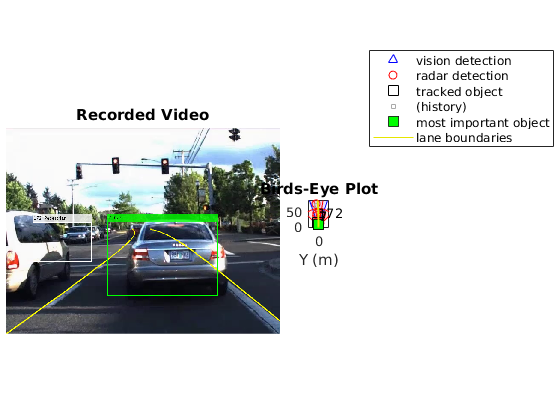

In [1]:
% Set up the display
[videoReader, videoDisplayHandle, bepPlotters, sensor] = helperCreateFCWDemoDisplay('01_city_c2s_fcw_10s.mp4', 'SensorConfigurationData.mat');

% Read the recorded detections file
[visionObjects, radarObjects, inertialMeasurementUnit, laneReports, ...
    timeStep, numSteps] = readSensorRecordingsFile('01_city_c2s_fcw_10s_sensor.mat');

% An initial ego lane is calculated. If the recorded lane information is
% invalid, define the lane boundaries as straight lines half a lane
% distance on each side of the car
laneWidth = 3.6; % meters
egoLane = struct('left', [0 0 laneWidth/2], 'right', [0 0 -laneWidth/2]);

% Prepare some time variables
time = 0;           % Time since the beginning of the recording
currentStep = 0;    % Current timestep
snapTime = 9.3;     % The time to capture a snapshot of the display

% Initialize the tracker
[tracker, positionSelector, velocitySelector] = setupTracker();

while currentStep < numSteps && ishghandle(videoDisplayHandle)
    % Update scenario counters
    currentStep = currentStep + 1;
    time = time + timeStep;

    % Process the sensor detections as objectDetection inputs to the tracker
    [detections, laneBoundaries, egoLane] = processDetections(...
        visionObjects(currentStep), radarObjects(currentStep), ...
        inertialMeasurementUnit(currentStep), laneReports(currentStep), ...
        egoLane, time);

    % Using the list of objectDetections, return the tracks, updated to time
    confirmedTracks = updateTracks(tracker, detections, time);

    % Find the most important object and calculate the forward collision
    % warning
    mostImportantObject = findMostImportantObject(confirmedTracks, egoLane, positionSelector, velocitySelector);

    % Update video and birds-eye plot displays
    frame = readFrame(videoReader);     % Read video frame
    helperUpdateFCWDemoDisplay(frame, videoDisplayHandle, bepPlotters, ...
        laneBoundaries, sensor, confirmedTracks, mostImportantObject, positionSelector, ...
        velocitySelector, visionObjects(currentStep), radarObjects(currentStep));

    % Capture a snapshot
    if time >= snapTime && time < snapTime + timeStep
        snapnow;
    end
end


## Create the Multi-Object Tracker
The multiObjectTracker tracks the objects around the ego vehicle based on the object lists reported by the vision and radar sensors. By fusing information from both sensors, the probabilty of a false collision warning is reduced.

The setupTracker function returns the multiObjectTracker. When creating a multiObjectTracker, consider the following:

1. FilterInitializationFcn: The likely motion and measurement models. In this case, the objects are expected to have a constant acceleration motion. Although you can configure a linear Kalman filter for this model, initConstantAccelerationFilter configures an extended Kalman filter. See the 'Define a Kalman filter' section.
2. AssignmentThreshold: How far detections can fall from tracks. The default value for this parameter is 30. If there are detections that are not assigned to tracks, but should be, increase this value. If there are detections that get assigned to tracks that are too far, decrease this value. This example uses 35.
3. NumCoastingUpdates: How many times a track is coasted before deletion. Coasting is a term used for updating the track without an assigned detection (predicting). The default value for this parameter is 5. In this case, the tracker is called 20 times a second and there are two sensors, so there is no need to modify the default.
4. ConfirmationParameters: The parameters for confirming a track. A new track is initialized with every unassigned detection. Some of these detections might be false, so all the tracks are initialized as 'Tentative'. To confirm a track, it has to be detected at least M times in N tracker updates. The choice of M and N depends on the visibility of the objects. This example uses the default of 2 detections out of 3 updates.

The outputs of setupTracker are:

1. tracker - The multiObjectTracker that is configured for this case.
2. positionSelector - A matrix that specifies which elements of the State vector are the position: position = positionSelector * State
3. velocitySelector - A matrix that specifies which elements of the State vector are the velocity: velocity = velocitySelector * State

## Define a Kalman Filter

The multiObjectTracker defined in the previous section uses the filter initialization function defined in this section to create a Kalman filter (linear, extended, or unscented). This filter is then used for tracking each object around the ego vehicle.

## Process and Format the Detections

The recorded information must be processed and formatted before it can be used by the tracker. This has the following steps:

Cleaning the radar detections from unnecessary clutter detections. The radar reports many objects that correspond to fixed objects, which include: guard-rails, the road median, traffic signs, etc. If these detections are used in the tracking, they create false tracks of fixed objects at the edges of the road and therefore must be removed before calling the tracker. Radar objects are considered nonclutter if they are either stationary in front of the car or moving in its vicinity.
Formatting the detections as input to the tracker, i.e., an array of objectDetection elements. See the processVideo and processRadar supporting functions at the end of this example.

## Update the Tracker

To update the tracker, call the updateTracks method with the following inputs:

1. tracker - The multiObjectTracker that was configured earlier. See the 'Create the Multi-Object Tracker' section.
2. detections - A list of objectDetection objects that was created by processDetections
3. time - The current scenario time.

The output from the tracker is a struct array of tracks.

## Find the Most Important Object and Issue a Forward Collision Warning

The most important object (MIO) is defined as the track that is in the ego lane and is closest in front of the car, i.e., with the smallest positive x value. To lower the probability of false alarms, only confirmed tracks are considered.

Once the MIO is found, the relative speed between the car and MIO is calculated. The relative distance and relative speed determine the forward collision warning. There are 3 cases of FCW:

1. Safe (green): There is no car in the ego lane (no MIO), the MIO is moving away from the car, or the distance is maintained constant.
2. Caution (yellow): The MIO is moving closer to the car, but is still at a distance above the FCW distance. FCW distance is calculated using the Euro NCAP AEB Test Protocol. Note that this distance varies with the relative speed between the MIO and the car, and is greater when the closing speed is higher.
3. Warn (red): The MIO is moving closer to the car, and its distance is less than the FCW distance.
Euro NCAP AEB Test Protocol defines the following distance calculation:

$d_{FCW} = 1.2 * v_{rel} + \frac{v_{rel}^2}{2a_{max}}$

where:

$d_{FCW}$ is the forward collision warning distance.

$v_{rel}$ is the relative velocity between the two vehicles.

$a_{max}$ is the maximum deceleration, defined to be 40% of the gravity acceleration.